In [1]:
import zipfile
import os
with zipfile.ZipFile("Assignment Data-20250323T070923Z-001.zip", "r") as zip_ref:
    zip_ref.extractall("QRData")

print("Extracted files:", os.listdir("QRData"))

Extracted files: ['Assignment Data']


In [25]:
!pip install lightning torch torchvision pandas numpy scikit-learn opencv-python matplotlib seaborn tqdm scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 206.7 MB/s eta 0:00:00


In [30]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


Total images: 200
First Print images: 100
Second Print images: 100


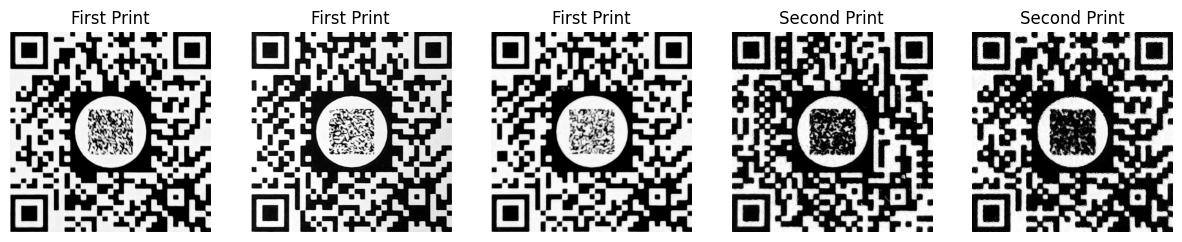

In [31]:
def load_images(root_dir):
    image_paths = []
    labels = []

    for label, category in enumerate(["First Print", "Second Print"]):
        category_path = os.path.join(root_dir, category)
        if os.path.exists(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                image_paths.append(img_path)
                labels.append(label)

    return image_paths, labels

dataset_path = "QRData/Assignment Data"

image_paths, labels = load_images(dataset_path)

print(f"Total images: {len(image_paths)}")
print(f"First Print images: {labels.count(0)}")
print(f"Second Print images: {labels.count(1)}")

#sample images
fig, axes = plt.subplots(1, 5, figsize=(15,5))
for i, idx in enumerate(np.random.choice(len(image_paths), 5, replace=False)):
    img = cv2.imread(image_paths[idx], cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title("First Print" if labels[idx] == 0 else "Second Print")
    axes[i].axis("off")

plt.show()


In [38]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from skimage.filters import sobel
from scipy.stats import entropy
from scipy.fftpack import fft2

#feature extraction
def extract_features(image):
    if image is None:
        return np.zeros(2000)  

    image = cv2.resize(image, (64, 64))  
    image = np.array(image, dtype=np.float32)  

    hog_features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    edge_features = sobel(image).flatten()

    gray_image = cv2.convertScaleAbs(image)  
    blur_measure = [cv2.Laplacian(gray_image, cv2.CV_64F).var()]

    hist, _ = np.histogram(image.ravel(), bins=256, range=(0, 256))
    entropy_value = [entropy(hist)]

    fft_features = np.abs(fft2(image)).flatten()[:500]  

    features = np.hstack((hog_features, edge_features, blur_measure, entropy_value, fft_features))
    return features


def load_dataset(root_dir):
    features = []
    labels = []

    for label, category in enumerate(["First Print", "Second Print"]):
        category_path = os.path.join(root_dir, category)
        if os.path.exists(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if image is None:
                    print(f"Skipping corrupted file: {img_path}")
                    continue
                
                feat = extract_features(image)
                features.append(feat)
                labels.append(label)

    return np.array(features), np.array(labels)

dataset_path = "QRData/Assignment Data"
X, y = load_dataset(dataset_path)

print(f"Feature extraction complete! Feature shape: {X.shape}, Labels shape: {y.shape}")


Feature extraction complete! Feature shape: (200, 6362), Labels shape: (200,)


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("📌 Random Forest Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"✅ Precision: {precision_score(y_test, y_pred):.4f}")
print(f"✅ Recall: {recall_score(y_test, y_pred):.4f}")
print(f"✅ F1-score: {f1_score(y_test, y_pred):.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


📌 Random Forest Model Performance:
✅ Accuracy: 1.0000
✅ Precision: 1.0000
✅ Recall: 1.0000
✅ F1-score: 1.0000

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



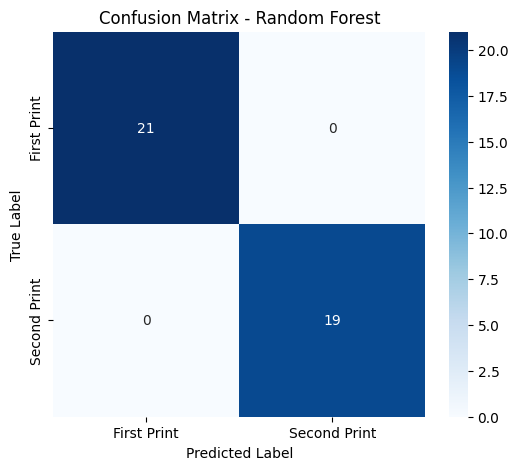

In [52]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["First Print", "Second Print"], yticklabels=["First Print", "Second Print"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [53]:
import numpy as np

misclassified_idxs = np.where(y_test != y_pred)[0]
print(f"🔍 Misclassified Samples Count: {len(misclassified_idxs)}")

def plot_misclassified(images, true_labels, pred_labels, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(misclassified_idxs[:num_samples]):
        img = images[idx]
        true_label = true_labels[idx]
        pred_label = pred_labels[idx]

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_label} | Pred: {pred_label}")
        plt.axis('off')

    plt.suptitle("Misclassified Images - Random Forest")
    plt.show()

plot_misclassified(X_test, y_test, y_pred, num_samples=5)


🔍 Misclassified Samples Count: 0


<Figure size 1000x500 with 0 Axes>

In [42]:
class QRCodeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, category in enumerate(["First Print", "Second Print"]):
            category_path = os.path.join(root_dir, category)
            if os.path.exists(category_path):
                for img_name in os.listdir(category_path):
                    self.image_paths.append(os.path.join(category_path, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128))

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = QRCodeDataset(dataset_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [43]:
class QRCodeCNN(nn.Module):
    def __init__(self):
        super(QRCodeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [45]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.clone().detach().to(device)  

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  
        correct += (predicted == labels).sum().item()  
        total += labels.size(0) 
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = (correct / total) * 100  

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1/10, Loss: 0.2860, Accuracy: 91.00%
Epoch 2/10, Loss: 0.1983, Accuracy: 89.50%
Epoch 3/10, Loss: 0.2614, Accuracy: 88.50%
Epoch 4/10, Loss: 0.1825, Accuracy: 93.50%
Epoch 5/10, Loss: 0.1892, Accuracy: 90.50%
Epoch 6/10, Loss: 0.1446, Accuracy: 95.50%
Epoch 7/10, Loss: 0.1240, Accuracy: 92.50%
Epoch 8/10, Loss: 0.0794, Accuracy: 99.50%
Epoch 9/10, Loss: 0.0462, Accuracy: 99.00%
Epoch 10/10, Loss: 0.0351, Accuracy: 99.50%


In [47]:
model.load_state_dict(torch.load("cnn_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.clone().detach().to(device) 
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.60      0.75       100
           1       0.71      1.00      0.83       100

    accuracy                           0.80       200
   macro avg       0.86      0.80      0.79       200
weighted avg       0.86      0.80      0.79       200



In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [58]:
#predictions
y_pred_rf = rf_model.predict(X_test)


In [59]:
print("📌 Random Forest Model Performance:")
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"✅ Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"✅ Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"✅ F1-score: {f1_score(y_test, y_pred_rf):.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_rf))


📌 Random Forest Model Performance:
✅ Accuracy: 1.0000
✅ Precision: 1.0000
✅ Recall: 1.0000
✅ F1-score: 1.0000

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [56]:
model.eval()
y_true, y_pred_cnn = [], []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.clone().detach().to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred_cnn.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred_cnn = np.array(y_pred_cnn)


In [57]:
print("\n📌 CNN Model Performance:")
print(f"✅ Accuracy: {accuracy_score(y_true, y_pred_cnn):.4f}")
print(f"✅ Precision: {precision_score(y_true, y_pred_cnn):.4f}")
print(f"✅ Recall: {recall_score(y_true, y_pred_cnn):.4f}")
print(f"✅ F1-score: {f1_score(y_true, y_pred_cnn):.4f}")
print("\n📊 Classification Report:\n", classification_report(y_true, y_pred_cnn))



📌 CNN Model Performance:
✅ Accuracy: 0.8000
✅ Precision: 0.7143
✅ Recall: 1.0000
✅ F1-score: 0.8333

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75       100
           1       0.71      1.00      0.83       100

    accuracy                           0.80       200
   macro avg       0.86      0.80      0.79       200
weighted avg       0.86      0.80      0.79       200



In [60]:
misclassified_idxs = np.where(y_test != y_pred_rf)[0]  
misclassified_cnn = np.where(y_true != y_pred_cnn)[0]  

print(f"🔍 Random Forest Misclassified Samples: {len(misclassified_idxs)}")
print(f"🔍 CNN Misclassified Samples: {len(misclassified_cnn)}")


🔍 Random Forest Misclassified Samples: 0
🔍 CNN Misclassified Samples: 40


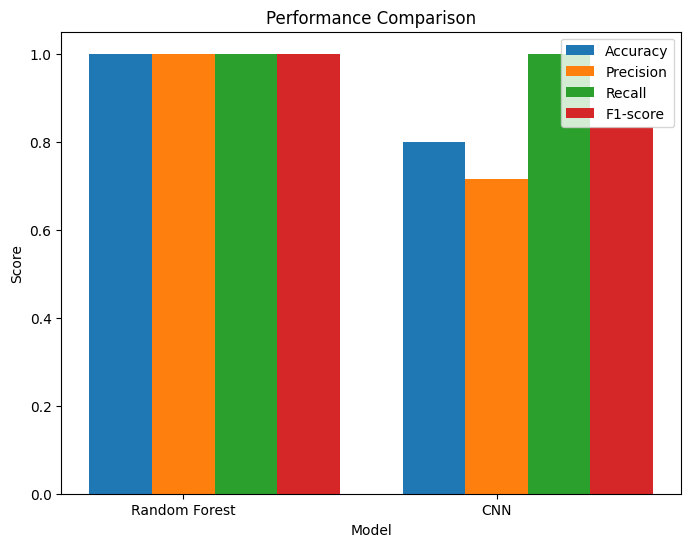

In [61]:
models = ["Random Forest", "CNN"]
accuracies = [accuracy_score(y_test, y_pred_rf), accuracy_score(y_true, y_pred_cnn)]
precisions = [precision_score(y_test, y_pred_rf), precision_score(y_true, y_pred_cnn)]
recalls = [recall_score(y_test, y_pred_rf), recall_score(y_true, y_pred_cnn)]
f1_scores = [f1_score(y_test, y_pred_rf), f1_score(y_true, y_pred_cnn)]


plt.figure(figsize=(8, 6))
X_axis = np.arange(len(models))
plt.bar(X_axis - 0.2, accuracies, 0.2, label="Accuracy")
plt.bar(X_axis, precisions, 0.2, label="Precision")
plt.bar(X_axis + 0.2, recalls, 0.2, label="Recall")
plt.bar(X_axis + 0.4, f1_scores, 0.2, label="F1-score")

plt.xticks(X_axis, models)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison")
plt.legend()
plt.show()
